In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

In [2]:
import os
GPU = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
dataset_name = 'ManyTx'
dataset_path='../../orbit_rf_dataset/data/compact_pkl_datasets/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

max_n = compact_dataset['max_sig']

equalized = 0

capture_date_list = compact_dataset['capture_date_list'][0]
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)


150 18


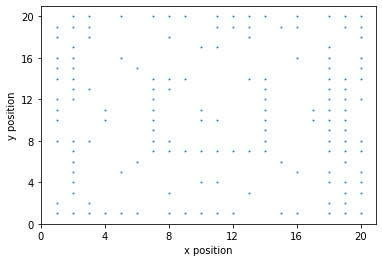

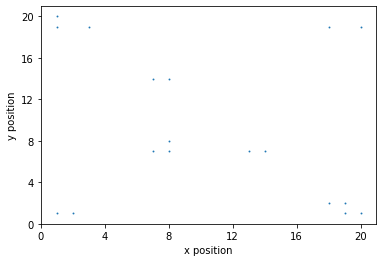

In [4]:
def plot_nodes(nl):
    x = []
    y = []
    for n in nl:
        #print(n)
        t = n.split("-")
        x.append(int(t[0]))
        y.append(int(t[1]))
    plt.scatter(x,y,s=0.8)
    plt.xticks(range(0,24,4))
    plt.yticks(range(0,24,4))
    plt.xlabel('x position')
    plt.ylabel('y position')
    return np.array([x,y]).T
    
tx_coordinates = plot_nodes(tx_list)
plt.figure()
rx_coordinates = plot_nodes(rx_list)

In [5]:

# avg = np.zeros((len(tx_list),n_rx))
# for i,tx in enumerate(tx_list):
#     for j,rx in enumerate(rx_list):
#         dataset = merge_datasets(capture_date_list,[tx],[rx], prefix=prefix,dataset_name=dataset_name)
#         dt= dataset['data'][0]
#         #print()
#         avg[i,j]=np.mean( np.sqrt(dt[:,:,0]**2+dt[:,:,1]**2))
# mx = np.nanmax(avg)
# mn = np.nanmin(avg)
# print(mx,mn)

In [6]:
mx = 0.19972752351638326
mn = 0.0052386050160007245
loc_data = np.zeros((len(tx_list),n_rx,max_n))
for i,tx in enumerate(tx_list):
    for j,rx in enumerate(rx_list):
        dataset = merge_compact_dataset(compact_dataset,capture_date_list,[tx],[rx], equalized=equalized)
        dt= dataset['data'][0]
        n = len(dt)
        
        loc_data[i,j,:n]=np.mean( np.sqrt(dt[:,:,0]**2+dt[:,:,1]**2),1)
        loc_data[i,j,n:]=np.random.uniform( mn,mx,size=max_n-n)

In [7]:
loc_data.shape

(150, 18, 50)

In [8]:
data_x = np.zeros((len(tx_list)*max_n,n_rx))
data_y = np.zeros((len(tx_list)*max_n,2))
for i in range(len(tx_list)):
    for j in range(max_n):
        data_x[i*max_n+j,:]=loc_data[i,:,j].flatten()
        data_y[i*max_n+j,0]=tx_coordinates[i,0]
        data_y[i*max_n+j,1]=tx_coordinates[i,1]

shfl = list(range(data_x.shape[0]))
np.random.seed(0)
np.random.shuffle(shfl)

data_x = data_x[shfl]
data_y = data_y[shfl]

tst_frac = 0.1
vld_frac = 0.1

tst_samp = int(tst_frac*data_x.shape[0])
val_samp = int(vld_frac*data_x.shape[0])

test_x=data_x[:tst_samp]
test_y=data_y[:tst_samp]
vld_x=data_x[tst_samp:tst_samp+val_samp]
vld_y=data_y[tst_samp:tst_samp+val_samp]
train_x=data_x[tst_samp+val_samp:]
train_y=data_y[tst_samp+val_samp:]


In [9]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samer/miniconda3/en

In [14]:
 def create_net():
    ap = lambda x,y: x+'_'+y
   

    inputs = Input(shape=(n_rx,))
    x = inputs
    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dense(2, activation=None,kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='mse',metrics=['mae'],optimizer=keras.optimizers.Adam(0.001))
    
    return classifier

create_net().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 162       
Total params: 10,142
Trainable params: 10,142
Non-trainable params: 0
_________________________________________________________________


In [15]:
TRAIN = True
patience = 5
n_epochs = 100


   
net = create_net()

fname_w = 'weights/d010.hd5'


filepath = 't_weights_'+GPU
if TRAIN:
    c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True),
      keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
    history = net.fit(train_x,train_y,
                             validation_data=(vld_x , vld_y),callbacks=c, epochs=n_epochs)
    net.load_weights(filepath)
    net.save_weights(fname_w,save_format="h5")
else:
    net.load_weights(fname_w)
        


res = net.evaluate(test_x,test_y,verbose=0)[1]


print(res)

    
    
    


Train on 6000 samples, validate on 750 samples
Epoch 1/100
6000/6000 [==============================] - 1s 138us/sample - loss: 73.5564 - mean_absolute_error: 7.0297 - val_loss: 37.0383 - val_mean_absolute_error: 5.3062
Epoch 2/100
6000/6000 [==============================] - 1s 93us/sample - loss: 28.6884 - mean_absolute_error: 4.5432 - val_loss: 20.1068 - val_mean_absolute_error: 3.6174
Epoch 3/100
6000/6000 [==============================] - 1s 101us/sample - loss: 16.7154 - mean_absolute_error: 3.1202 - val_loss: 15.1621 - val_mean_absolute_error: 2.9484
Epoch 4/100
6000/6000 [==============================] - 1s 91us/sample - loss: 14.5683 - mean_absolute_error: 2.8040 - val_loss: 13.7752 - val_mean_absolute_error: 2.7326
Epoch 5/100
6000/6000 [==============================] - 1s 98us/sample - loss: 13.7384 - mean_absolute_error: 2.6996 - val_loss: 13.0876 - val_mean_absolute_error: 2.6238
Epoch 6/100
6000/6000 [==============================] - 1s 94us/sample - loss: 13.0482 - m

In [16]:
net.evaluate(test_x,test_y,verbose=0)

[5.797635377248128, 1.5533133]

In [17]:
pred_y = np.round(net.predict(test_x))
np.mean(np.all(pred_y==test_y,1))

0.07866666666666666